## [Computational Social Science] Project 5: Natural Language Processing

Team 1: Sarah Lee, Alex Ramiller, and Hero Ashman

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#import random
import random

#sklearn functions
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
#congress_tweets.head()

congress_tweets.shape

(946791, 16)

In [77]:
# HA: my computer is being really slow so I took an even smaller sample of 5000
# make sure to reset index so they're numbered 0 onward
ct = congress_tweets.sample(5000, random_state=2).reset_index(drop = True)
ct.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,kamala_polarity,blackburn_polarity,kamala_subjectivity,blackburn_subjectivity
0,1.189970e+18,RepTipton,2019-10-31T14:16:58-04:00,#TBT: How to Pass a Wilderness Bill in 2014 (n...,Scott Tipton,Rep,3-Jan-11,11/9/1956,M,CO,3,Republican,"1,202,484","1,338,870","1,323,102","1,185,243",NaN,NaN,NaN,NaN
1,1.098400e+18,JoaquinCastrotx,2019-02-20T20:54:08-05:00,RT @AlexWardVox This is the most overlooked pa...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",NaN,NaN,NaN,NaN
2,1.267090e+18,RepTerriSewell,2020-05-31T09:38:12-04:00,The outrage we’re feeling is the culmination o...,Terri Sewell,Rep,3-Jan-11,1/1/1965,F,AL,7,Democrat,"1,318,255","729,547","795,696","1,255,925",NaN,NaN,NaN,NaN
3,1.172570e+18,RepSpeier,2019-09-13T14:16:47-04:00,"RT @RepColinAllred Over the past 25 years, the...",Jackie Speier,Rep,3-Jan-13,5/14/1950,F,CA,14,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",NaN,NaN,NaN,NaN
4,1.164320e+18,USRepKCastor,2019-08-21T19:26:14-04:00,I enjoyed seeing N. Tampa/Carrollwood neighbor...,Kathy Castor,Rep,3-Jan-07,8/20/1966,F,FL,14,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",NaN,NaN,NaN,NaN


In [4]:

#ct.groupby('party').count()
#Dem = 6468, Ind = 40, Rep = 3492

#ct.groupby('position').count()
#Representative = 7689, Senator = 2311

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [78]:
# Q: how can we remove emojis?
# Q: how can we remove \n and the like?

def rem_punc_stop(text):
    stop_words = STOP_WORDS 
    
    # incude additional stop words
    nlp.Defaults.stop_words |= {"RT", "QT", "amp"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text.lower() for token in doc]
    
    # remove URLs 
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [79]:
ct['tokens']= ct['text'].map(lambda x: rem_punc_stop(x))

In [80]:
# HA - might want to keep tokens as a list as opposed to a string (for later doc2vec)
ct['tokens'] = ct['tokens'].map(lambda text: ' '.join(text))

In [81]:
ct.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,kamala_polarity,blackburn_polarity,kamala_subjectivity,blackburn_subjectivity,tokens
0,1.189970e+18,RepTipton,2019-10-31T14:16:58-04:00,#TBT: How to Pass a Wilderness Bill in 2014 (n...,Scott Tipton,Rep,3-Jan-11,11/9/1956,M,CO,...,Republican,"1,202,484","1,338,870","1,323,102","1,185,243",NaN,NaN,NaN,NaN,tbt pass wilderness bill 2014 changed 2019 \n ...
1,1.098400e+18,JoaquinCastrotx,2019-02-20T20:54:08-05:00,RT @AlexWardVox This is the most overlooked pa...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,...,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",NaN,NaN,NaN,NaN,rt alexwardvox overlooked andrew mccabe saying...
2,1.267090e+18,RepTerriSewell,2020-05-31T09:38:12-04:00,The outrage we’re feeling is the culmination o...,Terri Sewell,Rep,3-Jan-11,1/1/1965,F,AL,...,Democrat,"1,318,255","729,547","795,696","1,255,925",NaN,NaN,NaN,NaN,outrage feeling culmination centuries injustic...
3,1.172570e+18,RepSpeier,2019-09-13T14:16:47-04:00,"RT @RepColinAllred Over the past 25 years, the...",Jackie Speier,Rep,3-Jan-13,5/14/1950,F,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",NaN,NaN,NaN,NaN,rt repcolinallred past 25 years violence women...
4,1.164320e+18,USRepKCastor,2019-08-21T19:26:14-04:00,I enjoyed seeing N. Tampa/Carrollwood neighbor...,Kathy Castor,Rep,3-Jan-07,8/20/1966,F,FL,...,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",NaN,NaN,NaN,NaN,enjoyed seeing n tampacarrollwood neighbors 1o...


In [8]:
ct['tokens'].iloc[0]

'TBT How Pass Wilderness Bill 2014 changed 2019 \n \n\n How CORE Act compare \n\n ❌ Give plenty time ⏰ \n ❌ Be prepared offer wilderness 🌲 \n ❌ Be willing compromise 🤝 \n ❌ Be prepared setbacks 🥾 🔙'

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

Below we plot a word cloud for Republicans, Democrats and Independents seperately. The word cloud visualizes words that come up frequently in their tweets. We can see a few trends that might be of interest. The Republican and Democrat clouds look pretty similar, both frequently tweeting generic words like "today", "thank" and "American". Interestingly, "Trump" shows up bigger for Democrats, while "realDonaldTrump" shows up for Republicams, which probably indicates that the Republicans are tweeting directly at Trump and the Democrats are tweeting about him. The cloud for the Independents looks very different, and is clearly made up of tweets from Bernie (we see "billion" and "million" come up a lot) and the other indepdent Senator from Maine. The fact that the word billion shows up twice in the word cloud suggests that they are being read as different words (maybe they have spaces attached to them?) and that is something we would want to clean up so that they are read as the same word.

In [9]:
ct_dems = ct[ct['party'] == 'Democrat']
ct_rep = ct[ct['party'] == 'Republican']
ct_ind = ct[ct['party'] == 'Independent']

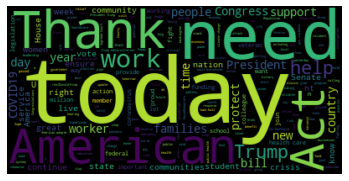

In [10]:
# Democrats
#text = ' '.join(ct_dems['tokens'].map(lambda text: ' '.join(text)))
text = ' '.join(ct_dems['tokens'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

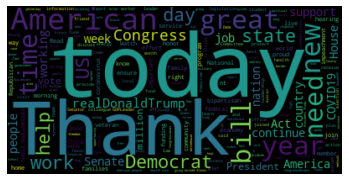

In [11]:
# Republicans
#text = ' '.join(ct_rep['tokens'].map(lambda text: ' '.join(text)))
text = ' '.join(ct_rep['tokens'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

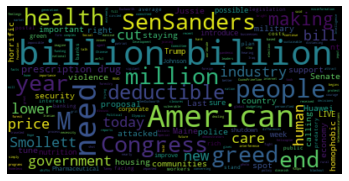

In [12]:
# Independents
#text = ' '.join(ct_ind['tokens'].map(lambda text: ' '.join(text)))
text = ' '.join(ct_ind['tokens'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### EDA 2

We create two text features: one with the character count (text length) of the tweets and another with the number of words per tweet. We create these for the tweets after having removed stop words and punctuation. We plot the distribution of both features below. Tweets are limited to 280 characters so we expect to see a spike around this text length (or a bit lower having removed stop words). There is a big drop off in word count around 30 words per tweet, and most tweets seem to be about 20 words long.  

In [82]:
#creating columns of text length and word count
ct['text_len'] = ct['tokens'].apply(len)
ct['text_wcount'] = ct['tokens'].apply(lambda x: len(str(x).split()))

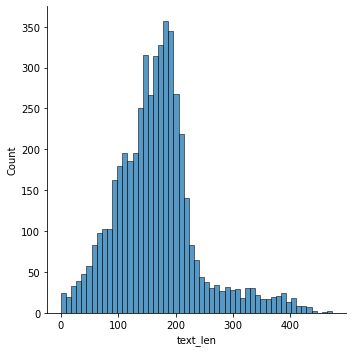

In [14]:
#plotting text length per tweet
sns.displot(ct, x="text_len")
plt.show()

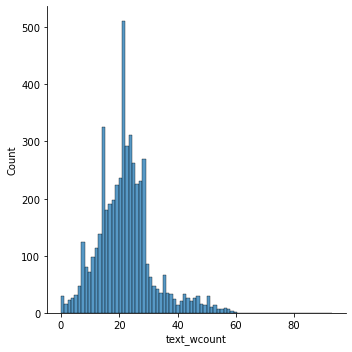

In [15]:
#plotting word count
sns.displot(ct, x="text_wcount")
plt.show()

In [16]:
#checking the means before plotting

mean_dem = ct[ct['party']=='Democrat']['text_wcount'].mean()
print("Average word count for Democrats:", mean_dem)
#word count = 39.11595547309833
#text length = 326.9157390228819

mean_rep = ct[ct['party']=='Republican']['text_wcount'].mean()
#word count = 35.71735395189003
#text length = 305.59192439862545
print("Average word count for Republicans:", mean_rep)


Average word count for Democrats: 22.77549751243781
Average word count for Republicans: 21.26534090909091


The plots below show word count per tweet split by the parties. We have an imbalanced sample with far more Democrat tweets that Republican and Independent so the counts are very different. The distributions are similar, though Democrats have slightly longer tweets than Republicans (shown above by their means). 

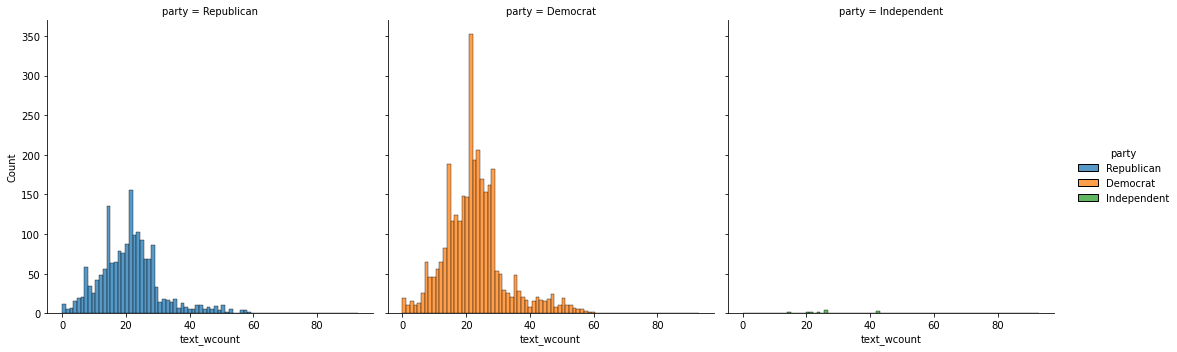

In [17]:
#plot comparison of word counts among Parties (Republican, Democrat, Independent)
sns.displot(ct, x="text_wcount", hue = "party", col = "party")
plt.show()

#Dems higher because more Dems in the data

We also have an imbalanced data set in terms of Representatives vs. Senators, with far more tweets from representative (preumably because there are more of them). Again, the distributions are similar, but it seems like on average Representatives have longer tweets. This is in keeping with Democrats also having longer tweets, and there being more Democrat Representatives than Republican. 

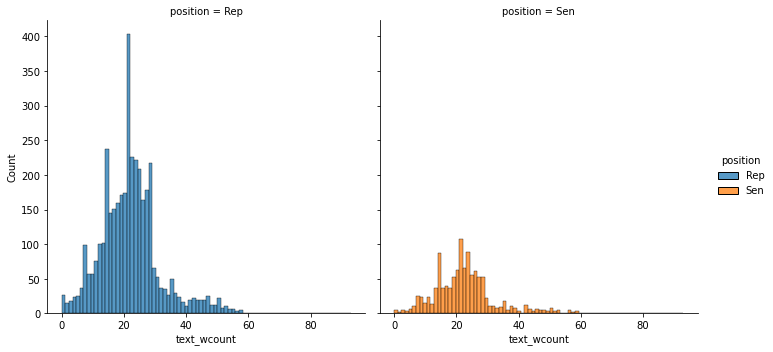

In [18]:
#plot comparison of word counts between Representatives and Senators
sns.displot(ct, x="text_wcount", hue = "position", col = "position")
plt.show()

#Reps higher because more Representatives in the data

Overall, we suspect that text features such as text length and word count will not be strong predictors of whether or not a tweet is from a Republican or a Democrat. 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### Senator Blackburn vs. Senator Harris 

To look at the tweets of the two Senators, we return to using the full collection of tweets (rather than our random sample). We use the pre-processed tweets to assess the sentimate of the texts. For the sentiment analysis for all Democrats and Republicans (below), we return to using our random sample and estimate sentiment based on the tokenized tweets. 

In [19]:
#Senator Blackburn (R) vs. Senator Harris (D)
#two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments

blackburn_text = congress_tweets[congress_tweets['name_wikipedia']=='Marsha Blackburn']['text']
blackburn_text

kamala_text = congress_tweets[congress_tweets['name_wikipedia']=='Kamala Harris']['text']
kamala_text

55173     Mexico isn’t paying for the wall and spending ...
55210     Congress showered corporations and the 1% with...
55235     An important moment in history as the 116th Co...
55237     The very first bill I’m introducing today, on ...
55336     If the shutdown continues not only will federa...
                                ...                        
157690    Thinking about the healthcare workers on the f...
157691    California continues to battle record numbers ...
157771    Wishing everyone in California and across the ...
157814    This past year was hard for so many. Millions ...
157815    This holiday weekend, we must stay vigilant an...
Name: text, Length: 2988, dtype: object

#### Sentiment
The sentiment polarity feature tries to asses how positive or negative a text is, with 1 being the most positive, 0 being neutral, and -1 being the most negative. The plots below show that for both Senators, their tweets are mainly neutral with some positive skew. We saw above that both Democrats and Republicans tweet the word "Thanks" and "great" a lot, which might contribute to their tweets being classified as more positive by their pre-trained model. 

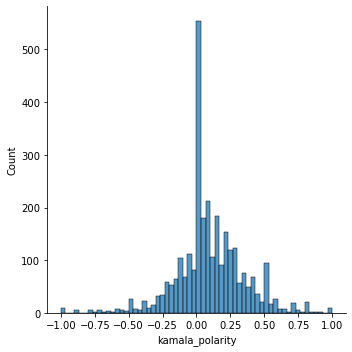

In [20]:
congress_tweets['kamala_polarity']= kamala_text.map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['blackburn_polarity']= blackburn_text.map(lambda text: TextBlob(text).sentiment.polarity)

sns.displot(congress_tweets, x="kamala_polarity")
plt.show()

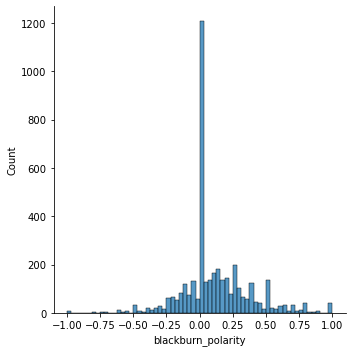

In [21]:
sns.displot(congress_tweets, x="blackburn_polarity")
plt.show()

#### Subjectivity
We can also assess the subjectivity of tweets. Here, 0 is the most objective and 1 is the most subjective. The plots below show that Kamala's tweets are generally considered more subjective than Blackburn's, although both have large clusters at 0, indicating objectivity. This might indicate that Democrat tweets will be classified as more subjective relative to Republicans (maybe because Republicans go to greater efforts to convince people they are telling the truth.) 

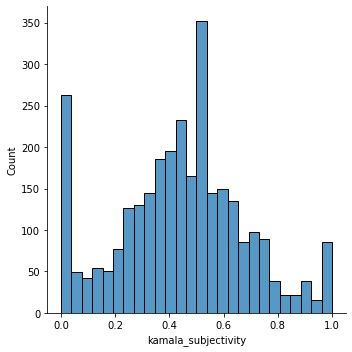

In [22]:
congress_tweets['kamala_subjectivity'] = kamala_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="kamala_subjectivity")
plt.show()

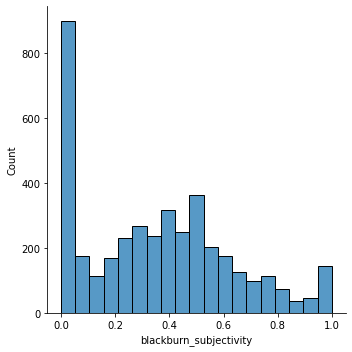

In [23]:
congress_tweets['blackburn_subjectivity'] = blackburn_text.map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="blackburn_subjectivity")
plt.show()

Comparing the polarity vs. subjectivity for both Senators, we see a clear relationship between subjectivity and more sentiment (both positive and negative. As Kamala's tweets become more subjective, they become more polarizing in both directions. However, as Blackburn's tweets become more subjective, they become more positive and not as negative. The difference in the relationship between polarity and subjectivity between Democrats and Republicans may be an important predictor for our model.  

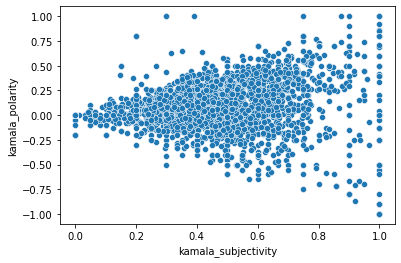

In [24]:
sns.scatterplot(data = congress_tweets, x = 'kamala_subjectivity', y = 'kamala_polarity')
plt.show()

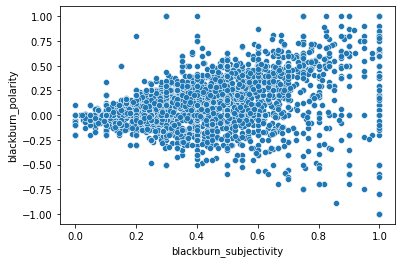

In [25]:
sns.scatterplot(data = congress_tweets, x = 'blackburn_subjectivity', y = 'blackburn_polarity')
plt.show()

### Democrats vs. Republicans
The same pattern that we observed for Senators Harris and Blackburn we also observe for Democrats and Republicans overall (in our random sample). For both parties, as subjectivity increases, the tweets become more polarizing. Both parties tweets become more positive the more subjective they get, however this relationship seems stronger for Republicans, while Democrat tweets also get increasingly negative. 

In [83]:
ct['polarity']= ct['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
ct['subjectivity']= ct['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

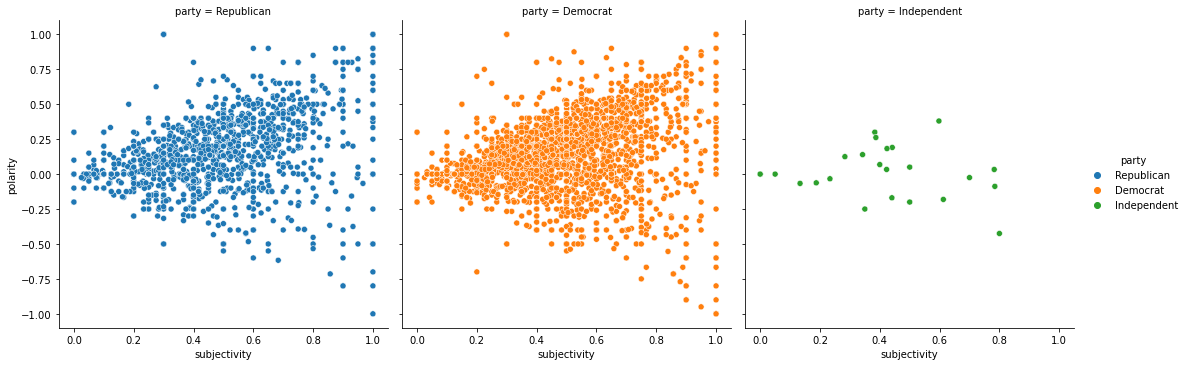

In [84]:
sns.relplot(
    data=ct, x="subjectivity", y="polarity",
    col="party", hue = "party", kind="scatter"
)
plt.show()

### Senators vs. Representatives
This pattern is mirrored for the Representatives and Senators, though the distinction is weaker. The Senate (which is majority Republican at this point) tweets increasingly positively as their subjectivity increases. For the house (which is majority Democrats), their tweets get both more negative and more positive. However, the two chambers show similar trends, which does not support the idea that Senators are more moderate in their discourse than Representatives. 

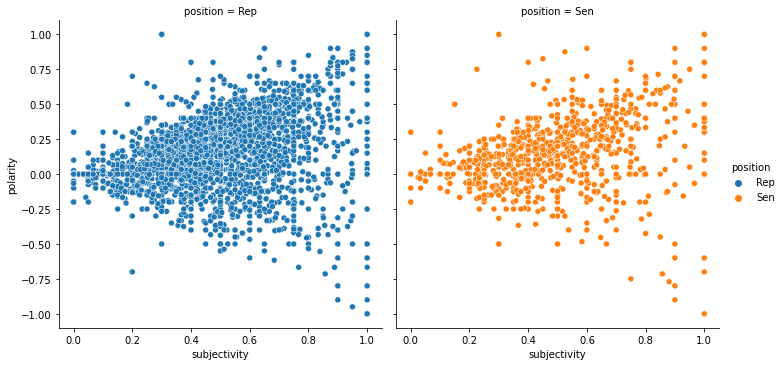

In [28]:
sns.relplot(
    data=ct, x="subjectivity", y="polarity",
    col="position", hue = "position", kind="scatter"
)
plt.show()

In [29]:
# OLD CODE
#(1) Sentiment Polarity between Democrats v. Republicans 
#using ct, a random 10000 slice of congress_tweets 

#dem_text = ct[ct['party']=='Democrat']['text']
#dem_text

#rep_text = ct[ct['party']=='Republican']['text']
#rep_text

#ct['dem_polarity']= dem_text.map(lambda text: TextBlob(text).sentiment.polarity)
#ct['rep_polarity']= rep_text.map(lambda text: TextBlob(text).sentiment.polarity)

#Plotting Sentiment Polarity for Democrats
#sns.displot(ct, x="dem_polarity")
#plt.show()

#Plotting Sentiment Polarity for Republicans
#sns.displot(ct, x="rep_polarity")
#plt.show()

#(2) Senators v. Representatives

#house_text = ct[ct['position']=='Rep']['text']
#house_text

#sen_text = ct[ct['position']=='Sen']['text']
#sen_text

#ct['house_polarity']= house_text.map(lambda text: TextBlob(text).sentiment.polarity)
#ct['sen_polarity']= sen_text.map(lambda text: TextBlob(text).sentiment.polarity)

#Plotting Sentiment Polarity for Representatives
#sns.displot(ct, x="house_polarity")
#plt.show()

#Plotting Sentiment Polarity for Senators
#sns.displot(ct, x="sen_polarity")
#plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Tf-idf
Tf-idf measures how relavant a word is within a corpus. It calculates the number of times a word appears in a document (a tweet) and divides it by how frequently the word shows up across the corpus (all of the tweets).

### Engineered Text Features

In [86]:
# Engineered Features
ct['party_mod'] = ct['party'].replace('Independent', 'Democrat')
engineered_features = ct[['text_len', 'text_wcount', 'polarity', 'subjectivity']].reset_index(drop = True)
engineered_features.head()

# Q: do we also want to do topic modelling?

,text_len,text_wcount,polarity,subjectivity
0,166,28,0.25,0.7500
1,81,13,0.00,0.0000
2,179,22,0.00,0.0000
3,189,25,-0.05,0.2500
4,207,29,0.35,0.4625


In [87]:
# Frequency Based featurization
X = ct['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)

tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

In [88]:
tfidf_df.shape

(5000, 18436)

In [89]:
tfidf_df.head()

,\n,\n\n,\n\n,\n\n \n,\n\n \n\n,\n\n \n\n \n\n,\n\n,\n\n \n\n,\n,\n \n,...,🧑,🧠,🧣,🧤,🧥,🧪,🧴,🧵,🧼,🩹
0,0.0,0.0,0.048227,0.0,0.0,0.0,0.0,0.0,0.231804,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.068760,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#list(tfidf_df.columns)

### Word Embedding

We use the Google News pre-trained word embedding model to get 300 dimension vectors for each word in our tweets. We find the average word embedding for each tweet and use that as features in our classification. Some tweets don't contain any words in the Google News corpus. 

In [36]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 


In [91]:
# turn tokens into a list, rather than a string
ct['tokens'] = [x.split(" ") for x in ct['tokens']]

In [128]:
# some tweets don't have any words that are in the Google corpus - eg #96
doc = [word for word in ct['tokens'][96] if word in model.wv.vocab]
len(doc)

<ipython-input-128-bf141d42db64>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  doc = [word for word in ct['tokens'][96] if word in model.wv.vocab]


0

In [96]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
# this function won't run if there are no words in tweet that are in the Google News model  
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [123]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    if len(doc) == 0:
        return np.zeros(300)
    else:
        return np.mean(model[doc], axis=0)

In [124]:
document_vector(model, []).shape

(300,)

In [125]:
document_vector(model, ['today']).shape

(300,)

In [126]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for doc in ct['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [129]:
# for tweets with no words, has returned a vector of 0 
doc_average_embeddings[96]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [130]:
# should be number of tweets x 300 (size of vectors from Google model)
doc_average_embeddings.shape

(5000, 300)

In [136]:
# Q: how many tweets contain no words in Google News? 34
sum(doc_average_embeddings == 0)

array([34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 34, 34, 34,
       34, 35, 35, 34, 34, 34, 34, 34, 34, 34, 34, 35, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 34, 35, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 38, 34, 34, 34, 35, 34, 34, 34, 35,
       34, 35, 34, 34, 35, 34, 35, 34, 35, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 36, 34, 34, 34, 35, 34, 34, 35, 35, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 34,
       34, 34, 34, 34, 34, 34, 34, 35, 34, 34, 35, 35, 34, 34, 34, 35, 35,
       34, 34, 35, 34, 34, 34, 34, 35, 34, 34, 34, 34, 35, 34, 34, 34, 34,
       35, 36, 34, 34, 34

In [131]:
# embedding based featurization
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

In [132]:
# create binary classes for relevant variables
lb_style = LabelBinarizer()
ct['position_binary'] = lb_style.fit_transform(ct['position'])
ct['party_binary'] = lb_style.fit_transform(ct['party_mod'])
print(ct['position_binary'].value_counts())
print(ct['party_binary'].value_counts())

0    3853
1    1147
Name: position_binary, dtype: int64
0    3240
1    1760
Name: party_binary, dtype: int64


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [133]:
# put all data frames together
dataframes = [engineered_features,
              tfidf_df,
              word2vec_features_df]

featurization_technique = ['Engineered Text Features',
                            'Tf-idf Features',
                          'Document Average Embeddings']

categories = ['position_binary',
              'party_binary']

labels = [['Representative', 'Senator'], ['Democrat', 'Republican']]

Logistic regressions are found to be completely ineffective at accurate prediction. We therefore use Random Forest instead.

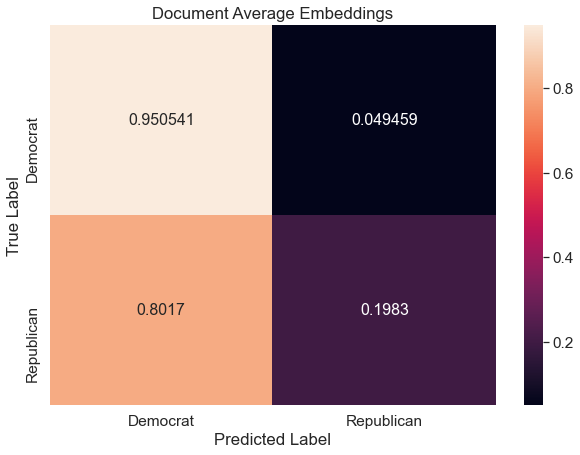

In [134]:
#Test run (to be removed)

dataframe = word2vec_features_df
featurization = 'Document Average Embeddings'
category = 'party_binary'
label = ['Democrat', 'Republican']

y = ct[category]
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
#logit_reg = LogisticRegression()
#logit_model = logit_reg.fit(X_train, y_train.ravel())
#y_pred = logit_model.predict(X_test)

# Create the random grid
#param_grid = {'criterion': ['gini', 'entropy'], 
#              'max_features': ['auto', 'sqrt', 'log2'],
#              'max_depth': list(np.arange(2,5,1)),
#              'min_samples_split': list(np.arange(2,5,1))}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

#rf_grid = GridSearchCV(rf,param_grid, cv = 3, n_jobs= -1, verbose = 2)
#rf_grid.fit(X_train, y_train)

#best_index = np.argmax(rf_grid.cv_results_["mean_test_score"])
#print(rf_grid.cv_results_["params"][best_index])

#rf = RandomForestClassifier(**rf_grid.cv_results_["params"][best_index])

rf_fit = rf.fit(X_train, y_train.ravel())
y_pred = rf_fit.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: label[0], 1: label[1]})
df_cm.index = [label[0], label[1]]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title(featurization)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
#rf_grid.cv_results_

Engineered Text Features---position_binary


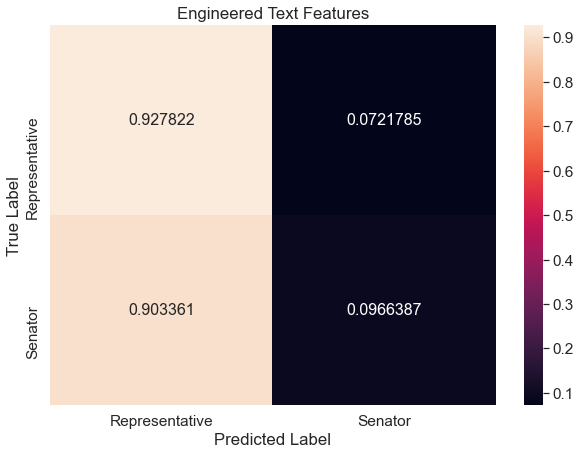

Engineered Text Features---party_binary


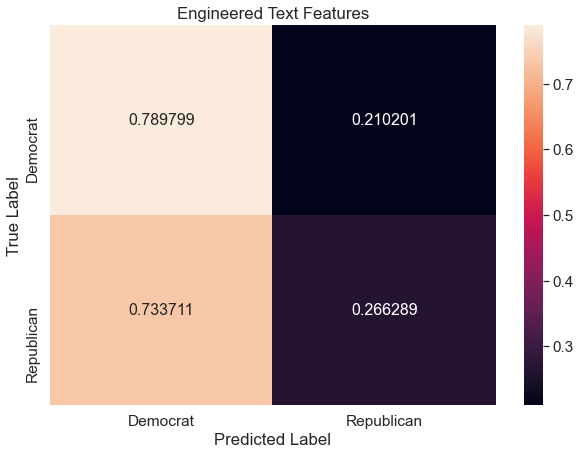

Tf-idf Features---position_binary


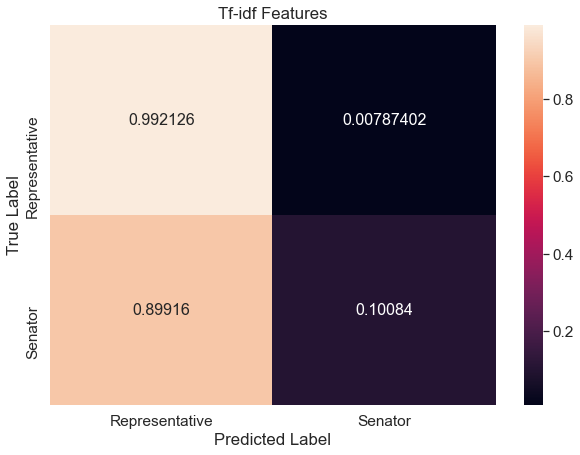

Tf-idf Features---party_binary


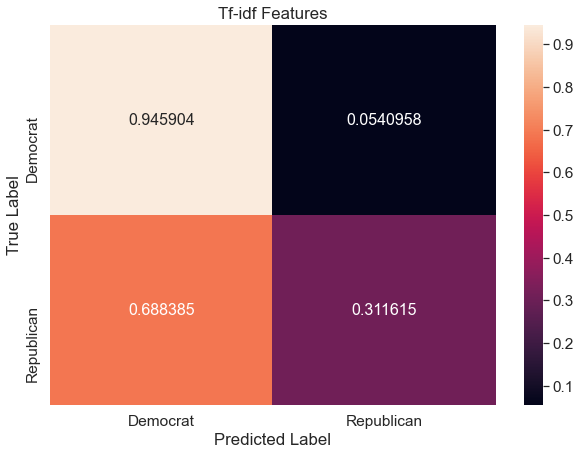

In [43]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
for dataframe, featurization in zip(dataframes, featurization_technique):
    for category, label in zip(categories, labels):
        print(featurization + "---" + category)
    
        y = ct[category]
    
        X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                            y, 
                                                            train_size = .80, 
                                                            test_size=0.20, 
                                                            random_state = 10)
        # Logistic regression (bad)
        #logit_reg = LogisticRegression()
        #logit_model = logit_reg.fit(X_train, y_train.ravel())
        #y_pred = logit_model.predict(X_test)

        # Random Forest model
        rf = RandomForestClassifier()
        # Fit RF model
        rf_fit = rf.fit(X_train, y_train.ravel())
        # Predict
        y_pred = rf_fit.predict(X_test)
    
        cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

        df_cm = pd.DataFrame(cf_matrix, range(2), range(2))

        df_cm = df_cm.rename(index=str, columns={0: label[0], 1: label[1]})
        df_cm.index = [label[0], label[1]]
        plt.figure(figsize = (10,7))
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, 
                   annot=True,
                   annot_kws={"size": 16},
                   fmt='g')

        plt.title(featurization)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

### Two Combined Models

In [44]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
ct.columns
non_text_features = ct[['trump_2016_state_share', 'clinton_2016_state_share', 
                        'obama_2012_state_share', 'romney_2012_state_share']]
non_text_features = non_text_features.replace({',':''}, regex=True)
non_text_features = non_text_features.apply(pd.to_numeric)
non_text_dummies = pd.get_dummies(ct[['gender', 'state']]).reset_index(drop = True)
non_text_features = non_text_features.reset_index(drop = True).join(non_text_dummies)
non_text_features

,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,gender_F,gender_M,state_AK,state_AL,state_AR,state_AZ,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1202484,1338870,1323102,1185243,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4685047,3877868,3308124,4569843,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1318255,729547,795696,1255925,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4483814,8753792,7854285,4839958,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4617886,4504975,4237756,4163447,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,319667,385234,415335,335788,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,1769443,1981473,1971820,1822522,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4997,1522925,870695,960709,1462330,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4998,2819533,4556118,4485741,2490431,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


position_binary


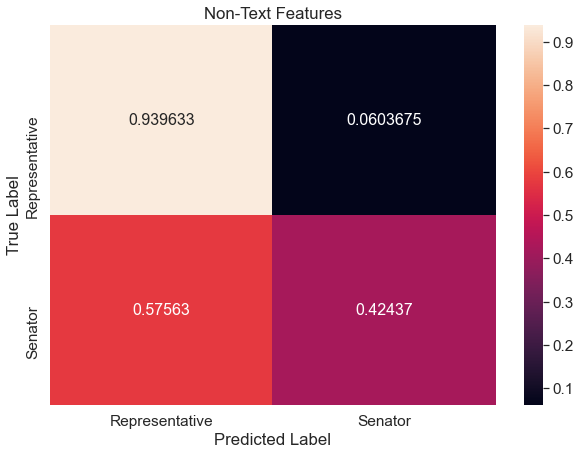

party_binary


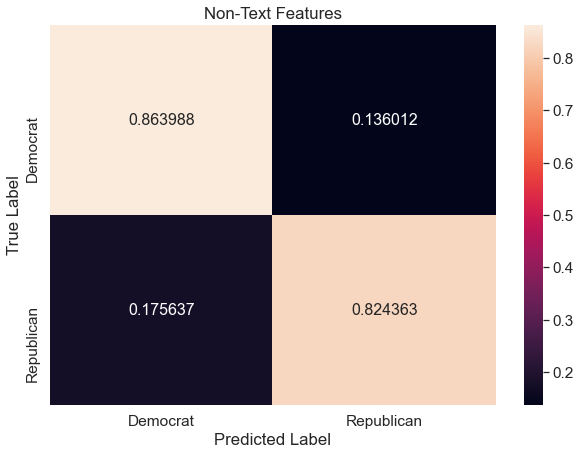

In [45]:
## Non-text model only

dataframe = non_text_features
featurization = "Non-Text Features"
for category, label in zip(categories, labels):
    print(category)
    
    y = ct[category]
    
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)

    # Random Forest model
    rf = RandomForestClassifier()
    # Fit RF model
    rf_fit = rf.fit(X_train, y_train.ravel())
    # Predict
    y_pred = rf_fit.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))

    df_cm = df_cm.rename(index=str, columns={0: label[0], 1: label[1]})
    df_cm.index = [label[0], label[1]]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
                annot=True,
                annot_kws={"size": 16},
                fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

position_binary


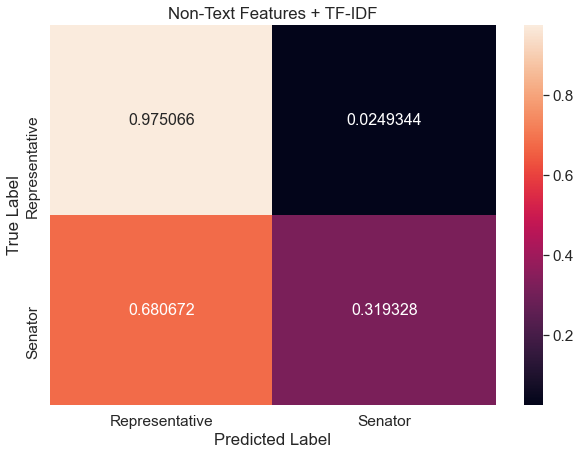

party_binary


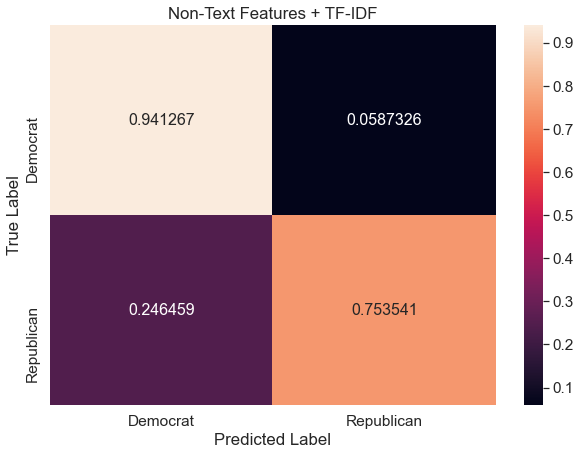

In [46]:
## Non-text plus text features from TF-IDF model (the best-performing feature-engineered model)

dataframe = tfidf_df.reset_index(drop = True).join(non_text_features)
featurization = "Non-Text Features + TF-IDF"
for category, label in zip(categories, labels):
    print(category)
    
    y = ct[category]
    
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)

    # Random Forest model
    rf = RandomForestClassifier()
    # Fit RF model
    rf_fit = rf.fit(X_train, y_train.ravel())
    # Predict
    y_pred = rf_fit.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))

    df_cm = df_cm.rename(index=str, columns={0: label[0], 1: label[1]})
    df_cm.index = [label[0], label[1]]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
                annot=True,
                annot_kws={"size": 16},
                fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Non-text features alone are the most effective variables for predicting political party and (to a lesser extent) political office.

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**